In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
path_to_csv = "../../Day1/amz_uk_price_prediction_dataset.csv"
df = pd.read_csv(path_to_csv)

In [14]:
df.isna().sum()

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

In [20]:
df.select_dtypes("number").columns

Index(['uid', 'stars', 'reviews', 'price', 'boughtInLastMonth'], dtype='object')

In [21]:
df.select_dtypes("object").columns

Index(['asin', 'title', 'category'], dtype='object')

In [26]:
df.drop("uid", inplace = True, axis = 1)

In [27]:
df.head()

,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


# Part 1: Analyzing Best-Seller Trends Across Product Categories

### Objective: 
Understand the relationship between product categories and their best-seller status.

### Crosstab Analysis:
- Create a crosstab between the product category and the isBestSeller status

In [28]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result.sort_values(by=True, ascending=False)

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


In [29]:
crosstab_result['Proportion_BestSeller'] = crosstab_result[True] / (crosstab_result[True] + crosstab_result[False])

In [30]:
sorted_crosstab = crosstab_result.sort_values(by='Proportion_BestSeller', ascending=False)

In [32]:
sorted_crosstab.head(10)

isBestSeller,False,True,Proportion_BestSeller
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
"Billiard, Snooker & Pool",241,8,0.032129
Pet Supplies,9152,285,0.030200
Home Brewing & Wine Making,239,7,0.028455
Wind Instruments,243,7,0.028000


### Part 1: Analyzing Best-Seller Trends Across Product Categories
 - Are there categories where being a best-seller is more prevalent?

No, in every category it is most prevalent to not be a best-seller. The categories with the highest number of products that are best sellers are grocery and smart home security and lighting

### 2 Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [48]:
crosstab_result.drop(['Proportion_BestSeller'], axis=1, inplace=True)

In [49]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

print(chi2_statistic)
print(chi2_p_value)

36540.20270061387
0.0


Since the p-value equals 0, we can reject the H0 and favor the H1 indicating there is a statistically significant relationship between the category of the products and if it is a best seller. The value of the Chi2 statistic being so large also provides evidence to reject the null hypothesis.

### 2 Statistical Tests:
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [50]:
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [52]:
from scipy.stats.contingency import association


association(crosstab_result, method="cramer")

0.1222829439760564

Since this value is close to 0 we can determine that there is a weak association between the two colums

### 3 Visualizations:
- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

<Axes: xlabel='category'>

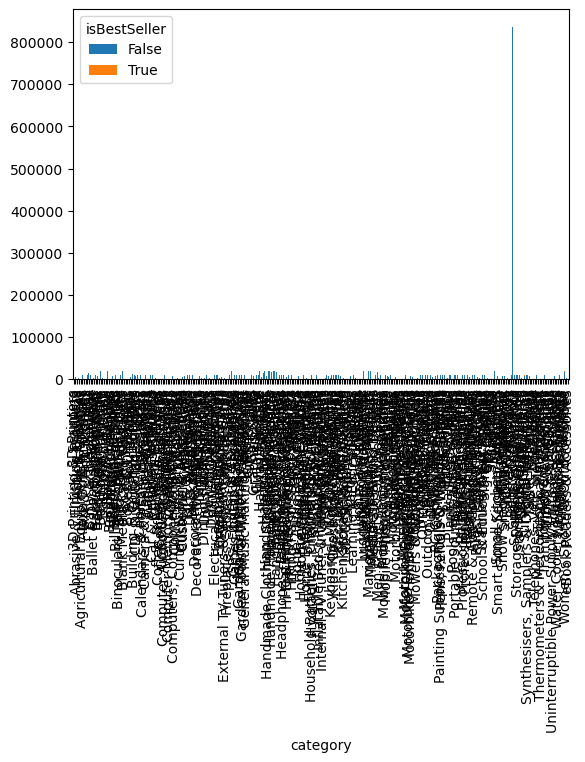

In [53]:
crosstab_result.plot(kind="bar", stacked=True)

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands

### Objective: 
Investigate how different product categories influence product prices.

0. Preliminary Step: Remove outliers in product prices.

        For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

        Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [56]:
df.price.unique()

array([ 21.99,  23.99,  31.99, ..., 358.42, 341.67, 317.34])

In [58]:
Q3 = df['price'].quantile(0.75)
Q1 = df['price'].quantile(0.25)
IQR = Q3 - Q1
lower_wisker = Q1 - 1.5*IQR
upper_wisker = Q3 + 1.5*IQR
list(df.columns).index('price')
lower_outliers_indexes = df[df['price'] < lower_wisker].index
upper_outliers_indexes = df[df['price'] > upper_wisker].index

# Replace the value of the upper_outliers with the value of the upper wisker
# Replace the value of the lower_outliers with the value of the lower wisker
df.iloc[lower_outliers_indexes,list(df.columns).index('price')] = lower_wisker
df.iloc[upper_outliers_indexes,list(df.columns).index('price')] = upper_wisker

In [59]:
df.price.unique()

array([21.99, 23.99, 31.99, ..., 97.71, 96.44, 88.87])

### 1. Violin Plots:
- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

In [74]:
top_categories = df.category.value_counts().sort_values(ascending=False).head(20).index

In [76]:
filtered_df = df[df['category'].isin(top_categories)]

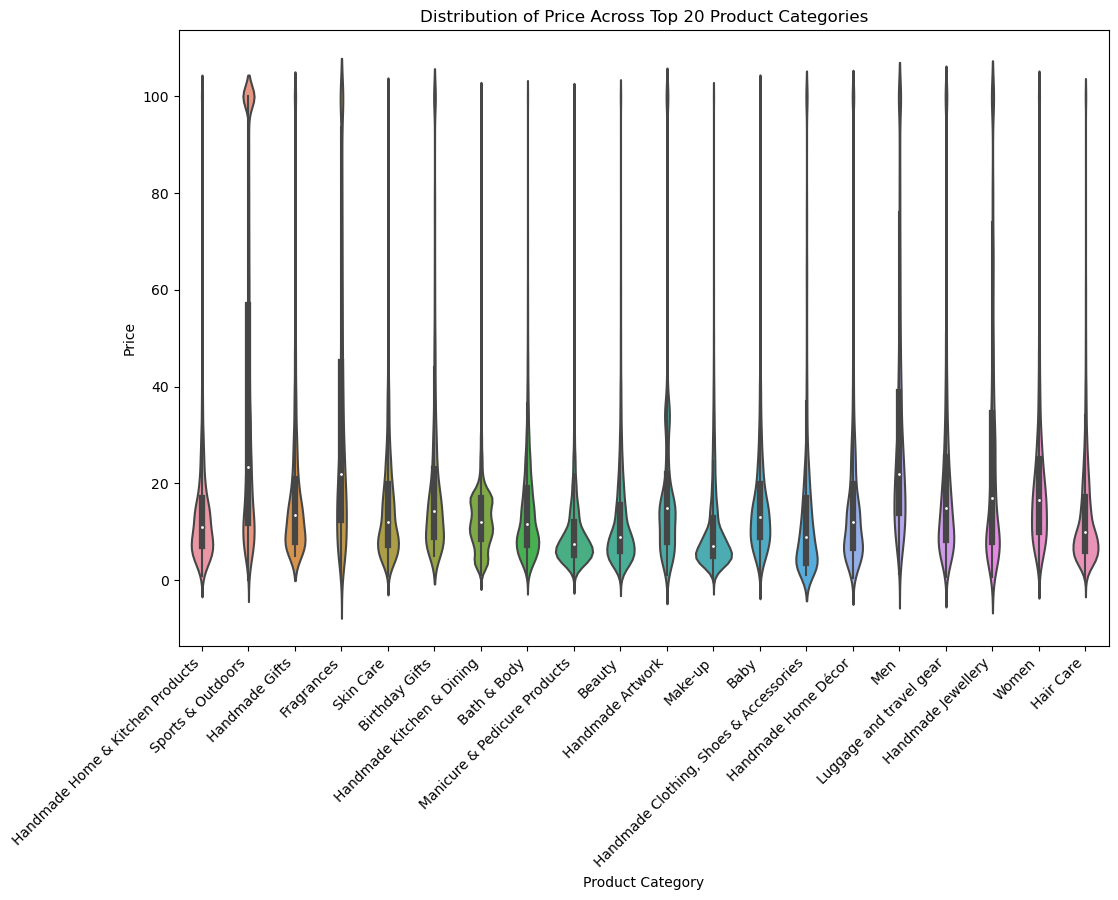

In [79]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='price', data=filtered_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.title('Distribution of Price Across Top 20 Product Categories')
plt.show()

#### Which product category tends to have the highest median price? Don't filter here by top categories.

In [86]:
agg_table = df.groupby('category')['price'].agg('median')
agg_table.sort_values(ascending=False).head(30)

category
3D Printers                            99.990
Motorbike Exhaust & Exhaust Systems    99.990
Binoculars, Telescopes & Optics        99.990
Home Entertainment                     99.990
Projectors                             99.990
Downhill Ski Boots                     99.990
Laptops                                99.990
PA & Stage                             99.990
CPUs                                   99.990
Digital Frames                         99.990
Bedding Collections                    99.990
Motorbike Boots & Luggage              99.990
Desktop PCs                            99.990
Motherboards                           99.990
Monitors                               99.990
Decking & Fencing                      99.990
Computer Printers                      99.990
Lab & Scientific Products              99.990
Home Audio Record Players              99.990
Lenses                                 99.990
Snowboards                             99.990
Wind Instruments         

### 2. Bar Charts:
- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

In [87]:
top_categories2 = df.category.value_counts().sort_values(ascending=False).head(10).index

In [88]:
filtered_df2 = df[df['category'].isin(top_categories2)]

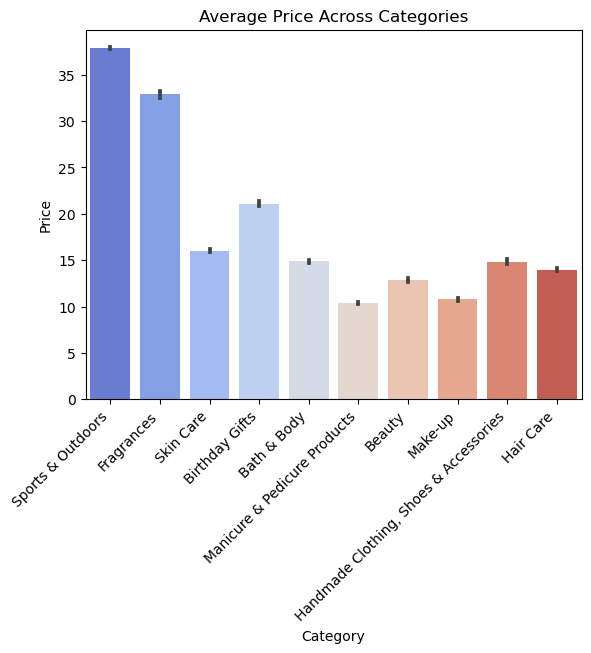

In [93]:
barplot = sns.barplot(data=filtered_df2, x='category', y='price', palette='coolwarm')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')

plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Average Price Across Categories')
plt.show()

#### Which product category commands the highest average price? Don't filter here by top categories.

In [100]:
agg_table2 = df.groupby('category')['price'].agg('mean')
agg_table2.sort_values(ascending=False).head(30)

category
Laptops                                99.429966
Desktop PCs                            99.234141
3D Printers                            93.566573
Motorbike Exhaust & Exhaust Systems    93.127946
Graphics Cards                         92.003936
Motherboards                           91.070695
Digital Frames                         84.271770
Alexa Built-In Devices                 83.200935
Snowboards                             83.172922
Home Audio Record Players              83.120259
Home Entertainment                     82.599184
Downhill Ski Boots                     82.140319
Snowboard Boots                        81.596356
PA & Stage                             80.880069
Motorbike Boots & Luggage              80.426400
Tablets                                80.284671
Lenses                                 80.131861
CPUs                                   79.961205
Decking & Fencing                      79.724672
Projectors                             78.584477
Monitors   

### 3 Box Plots:
- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

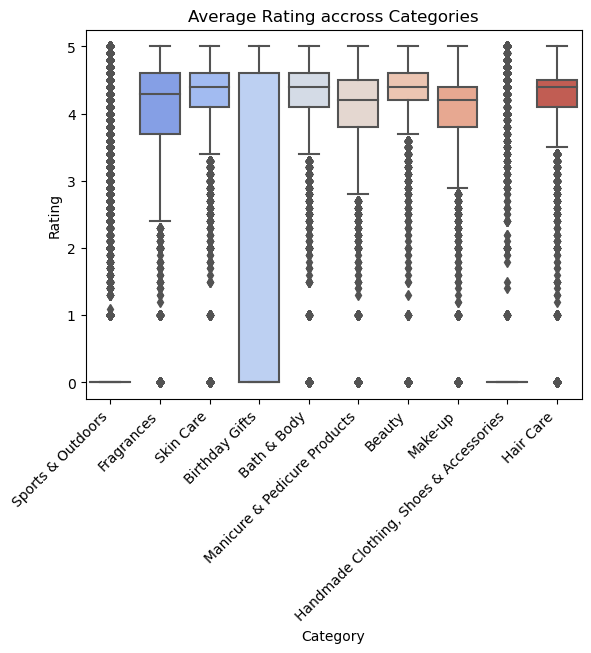

In [96]:
boxplot = sns.boxplot(data=filtered_df2, x='category', y='stars', palette='coolwarm')
boxplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')

plt.xlabel('Category')
plt.ylabel('Rating')
plt.title('Average Rating accross Categories')
plt.show()

#### Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [99]:
agg_table3 = df.groupby('category')['stars'].agg('median')
agg_table3.sort_values(ascending=False).head(30)

category
Computer Memory                   4.7
Hobbies                           4.6
Beer, Wine & Spirits              4.6
Laptop Accessories                4.6
Kids' Play Figures                4.6
Building & Construction Toys      4.6
CPUs                              4.6
Office Paper Products             4.6
Luxury Food & Drink               4.6
Camera & Photo Accessories        4.5
Jigsaws & Puzzles                 4.5
Signs & Plaques                   4.5
Health & Personal Care            4.5
Ski Helmets                       4.5
Industrial Electrical             4.5
Dolls & Accessories               4.5
Children's Bedding                4.5
Computer Cases                    4.5
Boxes & Organisers                4.5
School & Educational Supplies     4.5
Hi-Fi & Home Audio Accessories    4.5
Smart Speakers                    4.5
Soft Toys                         4.5
Vases                             4.5
Cables & Accessories              4.5
Photo Frames                      4.5
Art

# Part 3: Investigating the Interplay Between Product Prices and Ratings

### Objective: 
Analyze how product ratings (stars) correlate with product prices.


### 1. Correlation Coefficients:
- Calculate the correlation coefficient between price and stars.


In [101]:
correlation = df['price'].corr(df['stars'])
correlation

-0.15718340676827428

#### Is there a significant correlation between product price and its rating?

a correlation coefficient of -0.1571 indicates a weak negative linear relationship between the variables. This means that as one variable increases, the other variable tends to decrease slightly, but the relationship is not very strong.

### 2. Visualizations:
- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

<Axes: xlabel='price', ylabel='stars'>

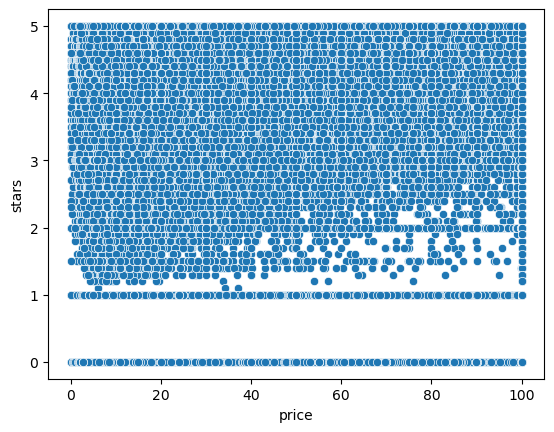

In [105]:
sns.scatterplot(data=df, x='price', y='stars')

Some products have no ratings and the price varies from 0 to 100, as do products with 1 star rating. Other than this I can see no relationship between these two columns.

#### Use a correlation heatmap to visualize correlations between all numerical variables.

In [106]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:,df.select_dtypes("number").nunique() < 20]

In [107]:
df_categorical = pd.concat([df.select_dtypes("object"), potential_categorical_from_numerical], axis=1)
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

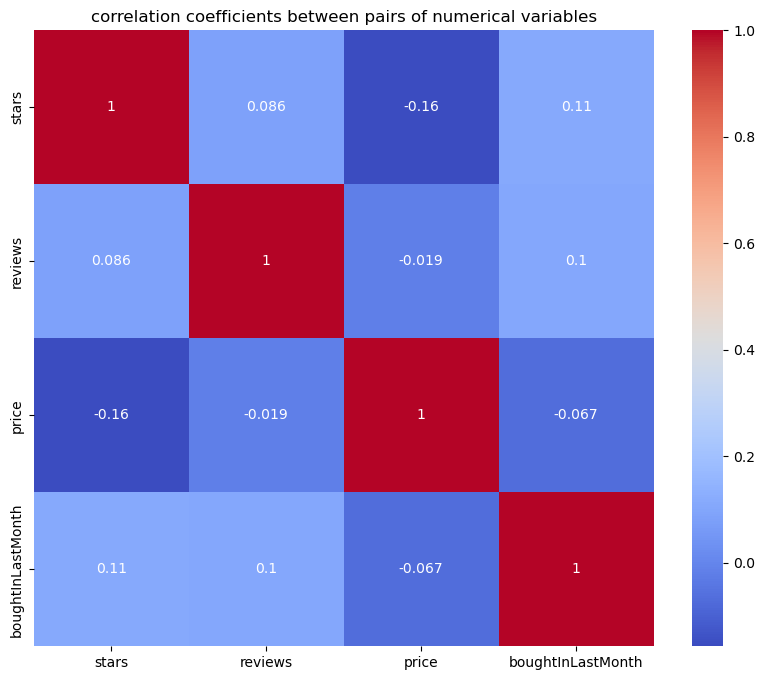

In [112]:
correlation_matrix = df_numerical.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('correlation coefficients between pairs of numerical variables')
plt.show()

#### Examine if product prices typically follow a normal distribution using a QQ plot.

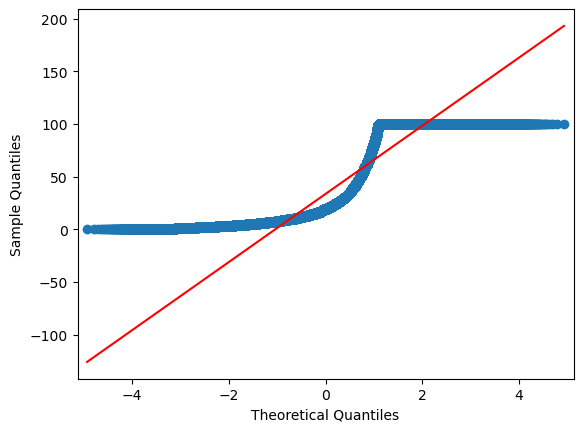

In [113]:
import statsmodels.api as sm

sm.qqplot(df['price'], line='s');